In [19]:
"""
Requirements
pip install scipy==1.9.3 scanpy igraph harmonypy gseapy adjustText
"""
import os

from anndata import AnnData
from adjustText import adjust_text

import scanpy as sc
import scipy.stats as ss
import pandas as pd
import harmonypy as hm
import numpy as np
import gseapy as gp
import matplotlib.pyplot as plt
import textwrap

# Define File Names
H5_FILENAME = 'GSE178341_crc10x_full_c295v4_submit.h5'
H5AD_FILENAME = H5_FILENAME.replace('.h5', '.h5ad')

CYTOTRACE_OUTFILE = 'cytotrace_input_normalized.csv'

QC_FILENAME = 'GSE178341_QC.h5ad'

CLUSTER_FILENAME = 'GSE178341_crc10x_full_c295v4_submit_cluster.csv'
METADATA_FILENAME = 'GSE178341_crc10x_full_c295v4_submit_metatables.csv'



In [ ]:
# Convert h5 to h5AD (Roughly 10 minutes)
if not os.path.exists(H5AD_FILENAME) and os.path.exists(H5_FILENAME):
    adata = sc.read_10x_h5(H5_FILENAME)
    adata.write_h5ad(H5AD_FILENAME)

In [ ]:
# Read h5AD File 
adata = sc.read_h5ad(H5AD_FILENAME)

In [ ]:
# Create Gene Expression Table to Upload into CytoTRACE (Roughly 13 minutes)
if not os.path.exists(CYTOTRACE_OUTFILE):
    # Convert Sparse to Dense Matrix
    dense_matrix = adata.X.toarray()

    # Create DataFrame
    df = pd.DataFrame(
        dense_matrix.T,  # Transpose Matrix to get into following format: [genes x cells]
        index=adata.var_names,  
        columns=adata.obs_names
    )

    # Export to CSV
    df.to_csv(CYTOTRACE_OUTFILE)

In [ ]:
# Identify mitochondrial genes (assuming human dataset with 'MT-' prefix)
adata.var["mt"] = adata.var_names.str.startswith("MT-")

# Compute QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

# View QC metrics
print(adata.obs[["total_counts", "n_genes_by_counts", "pct_counts_mt"]].head())

In [ ]:
# Define QC thresholds
min_genes = 200  # Cells must have at least 200 genes
max_genes = 5000  # Remove cells with very high gene counts
max_mt = 5  # Remove cells with >5% mitochondrial RNA

# Apply filtering
adata = adata[adata.obs.n_genes_by_counts > min_genes, :]
adata = adata[adata.obs.n_genes_by_counts < max_genes, :]
adata = adata[adata.obs.pct_counts_mt < max_mt, :]

print(f"Remaining cells after filtering: {adata.n_obs}")

In [ ]:
# Filter Out Low-Quality Genes
sc.pp.filter_genes(adata, min_cells=3)  # Keep genes present in at least 3 cells

In [ ]:
# Normalize & Log-Transform Data for downstream analysis
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [ ]:
# Identify Highly Variable Genes
# Select genes that show high variability across cells
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Keep only highly variable genes
adata = adata[:, adata.var.highly_variable]

print(f"Number of highly variable genes: {adata.shape[1]}")

In [ ]:
# Save the Processed Data
adata.write(QC_FILENAME)

In [2]:
"""
* * * * * * *
 START HERE!
* * * * * * *
"""
adata = sc.read_h5ad(QC_FILENAME)

In [86]:
# Add CytoTRACE Scores to adata
cytotrace_scores = pd.read_csv('CytoTRACE_scores.csv', index_col=0)
adata.obs['CytoTRACE'] = cytotrace_scores['x'] 

In [92]:
# Format data for Batch Correction
"""
FORMAT obs_names = C[PatientID]_[Region]_[X]_[Y]_[Z]_c[Cluster]_v[Version]_[Barcode]
T, N, TA, TB → Sample Type / Region
    T → Tumor sample
    N → Normal (adjacent) tissue
    TA, TB → Multiple tumor regions (possibly from different sections of the same tumor or replicates from the same patient)
"""
obs_names = adata.obs_names.str.split('_')
adata.obs["batch"] = obs_names.str[0]     # Patient IDs
adata.obs["region"] = obs_names.str[1]    # Sample Regions ()
print(adata.obs["batch"].value_counts())  # Number of cells per patient sample
print(adata.obs["region"].value_counts())

batch
C129    6895
C126    6013
C132    5579
C124    5026
C130    4283
        ... 
C168      90
C160      86
C172      83
C173      75
C161      33
Name: count, Length: 62, dtype: int64
region
T     61539
N     28852
TA     2960
TB     1942
Name: count, dtype: int64


In [93]:
def merge_csv(adata: AnnData, csv_filename: str, index_column: str, merge_column: str):
    # Prevent redundant merging
    if merge_column in adata.obs.columns:
        return

    # Read the CSV, extracting only the necessary columns
    csv = pd.read_csv(csv_filename)[[index_column, merge_column]]
    
    # Merge in the cluster information by matching the cell IDs
    adata.obs = adata.obs.reset_index()
    adata.obs = adata.obs.merge(csv, left_on='index', right_on=index_column, how='left')
    adata.obs = adata.obs.set_index('index')

    # Clean up duplicate column after merge
    adata.obs.drop(columns=[index_column], inplace=True)

In [94]:
# Read metadata
merge_csv(adata, METADATA_FILENAME, 'cellID', 'MMRStatus')

# Read Cell Type
merge_csv(adata, CLUSTER_FILENAME, 'sampleID', 'clTopLevel')
merge_csv(adata, CLUSTER_FILENAME, 'sampleID', 'clMidwayPr')


In [95]:
# Subset the data to only MMRD and MMRP cells
adata_sub = adata[adata.obs['MMRStatus'].isin(['MMRp', 'MMRd'])].copy()

# Perform DE Analysis 
sc.tl.rank_genes_groups(adata_sub, groupby="MMRStatus", method="wilcoxon")

# Extract DE results for MMRD vs MMRP
de_results = sc.get.rank_genes_groups_df(adata_sub, group="MMRd")

# Handle extreme values safely
de_results["pvals"].replace(0, 1e-300, inplace=True)  # Avoid log(0) errors
de_results["logfoldchanges"].replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaNs in logFC with 0 (neutral effect) & p-values with 1 (not significant)
de_results.fillna({"logfoldchanges": 0, "pvals": 1, "pvals_adj": 1}, inplace=True)

# Save Results
de_results.to_csv("MMRD_vs_MMRP_DEGs.csv", index=False)

# Show top genes
print(de_results.head(10))

    names     scores  logfoldchanges          pvals      pvals_adj
0    MT2A  52.256943        1.375977  1.000000e-300   0.000000e+00
1    CCL5  44.651451        1.872918  1.000000e-300   0.000000e+00
2    GZMB  43.182892        2.084113  1.000000e-300   0.000000e+00
3    GZMA  41.995499        1.913632  1.000000e-300   0.000000e+00
4    CCL4  39.764549        1.579251  1.000000e-300   0.000000e+00
5    NKG7  34.843288        1.526161  5.380654e-266  2.006087e-263
6    GNLY  32.978855        2.067555  1.632649e-238  5.217480e-236
7  CXCL13  30.376179        2.658653  1.133780e-202  3.170333e-200
8   KLRD1  30.329231        1.960532  4.721102e-202  1.173456e-199
9    MT1E  29.355377        1.494465  2.040225e-189  4.563982e-187


/var/folders/k9/6ny465s16b10fp__fsd7nx1w0000gn/T/ipykernel_23572/672158735.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  de_results["pvals"].replace(0, 1e-300, inplace=True)  # Avoid log(0) errors
/var/folders/k9/6ny465s16b10fp__fsd7nx1w0000gn/T/ipykernel_23572/672158735.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which

In [ ]:
# Create DE as Ranked List for GSEA (MMRp vs. MMRd)
# Set low p-value to avoid numerical instability
min_pval = 1e-50

# Replace small p-values with min_pval
de_results["safe_pval"] = de_results["pvals"].clip(lower=min_pval)

# Compute ranking score (logFC * -log10(p-value))
de_results["rank"] = de_results["logfoldchanges"] * -np.log10(de_results["safe_pval"])

# Handle infinities or NaNs
de_results["rank"].replace([np.inf, -np.inf], np.nan, inplace=True)
de_results["rank"].fillna(0, inplace=True)

# Save ranked list
de_results[["names", "rank"]].to_csv("gsea_ranked_genes.rnk", sep="\t", index=False, header=False)

/var/folders/k9/6ny465s16b10fp__fsd7nx1w0000gn/T/ipykernel_23572/1273143058.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  de_results["rank"].replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/k9/6ny465s16b10fp__fsd7nx1w0000gn/T/ipykernel_23572/1273143058.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we ar

Index(['Name', 'Term', 'ES', 'NES', 'NOM p-val', 'FDR q-val', 'FWER p-val',
       'Tag %', 'Gene %', 'Lead_genes'],
      dtype='object')
      Name                                               Term        ES  \
0  prerank  Creation of C4 and C2 activators Homo sapiens ... -0.960685   
1  prerank  Classical antibody-mediated complement activat... -0.961017   
2  prerank  Initial triggering of complement Homo sapiens ... -0.914751   
3  prerank       Complement cascade Homo sapiens R-HSA-166658 -0.894059   
4  prerank         Signaling by Wnt Homo sapiens R-HSA-195721  -0.87387   

        NES NOM p-val FDR q-val FWER p-val  Tag % Gene %  \
0  -1.69362       0.0  0.010858      0.008   4/25  0.31%   
1 -1.662383       0.0  0.015744      0.015   4/23  0.31%   
2   -1.6494       0.0   0.01701      0.022   4/28  0.31%   
3 -1.638904       0.0  0.019815      0.032   4/34  0.31%   
4 -1.519882  0.013937  0.247119      0.409  10/24  9.66%   

                                          Lead_ge

/Users/rosiepham/Desktop/BENG204/Group Project/.venv/lib/python3.13/site-packages/gseapy/plot.py:738: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[self.colname] = df[self.colname].replace(0, np.nan).bfill()


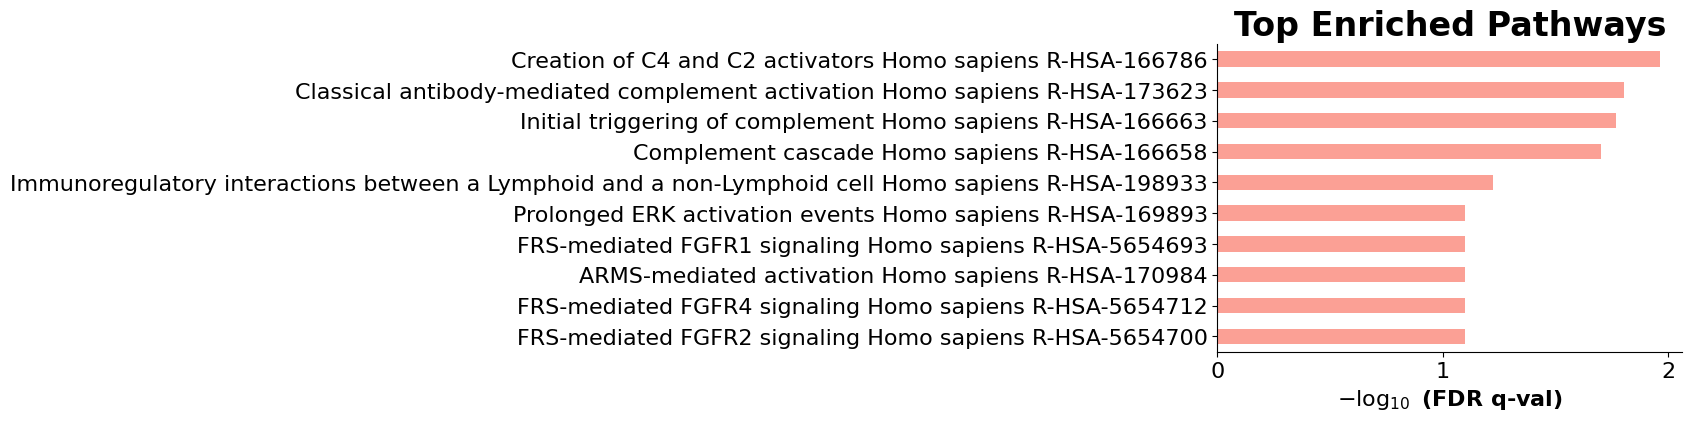

In [8]:
# Gene Set Enrichment Analysis Between MMRd and MMRp
gsea_results = gp.prerank(
    rnk="gsea_ranked_genes.rnk",
    gene_sets="Reactome_2016",  
    outdir="GSEA_results",
    seed=123,
    min_size=10,
    max_size=15000
)

# View the results
print(gsea_results.res2d.columns)
print(gsea_results.res2d.head())

# Plot the enrichment results
gp.barplot(
    gsea_results.res2d,
    title="Top Enriched Pathways",
    figsize=(6, 4),
    column="FDR q-val",  # Use the correct column name here
    cutoff=0.5
)
plt.show()

In [9]:
# Subset Tumor and Tumor Adjacent Normal Cells
adata_tumor = adata[adata.obs['region'] == 'T'].copy()
adata_normal = adata[adata.obs['region'] == 'N'].copy()
adata_combo = adata_normal.concatenate(adata_tumor, batch_key="group", batch_categories=["Normal", "Tumor"])

# Add a new column to indicate the group (Normal vs Tumor)
adata_combo.obs['group'] = ['Normal'] * len(adata_normal) + ['Tumor'] * len(adata_tumor)

/var/folders/k9/6ny465s16b10fp__fsd7nx1w0000gn/T/ipykernel_23572/471526480.py:4: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_combo = adata_normal.concatenate(adata_tumor, batch_key="group", batch_categories=["Normal", "Tumor"])


In [10]:
# Perform DE Analysis on Tumor and Tumor Adjacent Normal Cells
sc.tl.rank_genes_groups(adata_combo, groupby="group", method="wilcoxon")
de_results_normalt = sc.get.rank_genes_groups_df(adata_combo, group="Tumor")

# Handle extreme values safely
de_results_normalt["pvals"].replace(0, 1e-315, inplace=True)  # Avoid log(0) errors
de_results_normalt["logfoldchanges"].replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaNs in logFC with 0 & p-values with 1 
de_results_normalt.fillna({"logfoldchanges": 0, "pvals": 1, "pvals_adj": 1}, inplace=True)

# Save results to CSV
de_results_normalt.to_csv("Normal_vs_Tumor_DEGs.csv", index=False)

# Show top differentially expressed genes
print(de_results_normalt.head(15))

       names     scores  logfoldchanges          pvals  pvals_adj
0       SAT1  69.716988        1.603837  1.000000e-315        0.0
1     IFITM2  58.532425        1.713394  1.000000e-315        0.0
2   HLA-DRB1  57.451248        1.901219  1.000000e-315        0.0
3    HLA-DRA  56.911594        1.718589  1.000000e-315        0.0
4   HLA-DPB1  52.565212        1.564734  1.000000e-315        0.0
5        CD2  51.782337        2.352433  1.000000e-315        0.0
6        LYZ  51.408615        3.165063  1.000000e-315        0.0
7     IFITM3  50.146790        1.966421  1.000000e-315        0.0
8        TXN  49.224968        1.124350  1.000000e-315        0.0
9       CTSD  48.066059        1.877886  1.000000e-315        0.0
10     ANXA1  47.643257        1.830352  1.000000e-315        0.0
11      GLUL  46.838074        2.388913  1.000000e-315        0.0
12    SAMSN1  46.655228        2.062405  1.000000e-315        0.0
13      CCL5  45.527538        2.553822  1.000000e-315        0.0
14      GZ

/var/folders/k9/6ny465s16b10fp__fsd7nx1w0000gn/T/ipykernel_23572/1022175458.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  de_results_normalt["pvals"].replace(0, 1e-315, inplace=True)  # Avoid log(0) errors
/var/folders/k9/6ny465s16b10fp__fsd7nx1w0000gn/T/ipykernel_23572/1022175458.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object 

In [17]:
# Create DE as Ranked List for GSEA (Tumor vs. Tumor Adjacent Normal)
# Replace extremely small p-values with min_pval
de_results_normalt["safe_pval"] = de_results_normalt["pvals"].clip(lower=min_pval)

# Compute ranking score (logFC * -log10(p-value))
de_results_normalt["rank"] = de_results_normalt["logfoldchanges"] * -np.log10(de_results["safe_pval"])

# Handle infinities or NaNs
de_results_normalt["rank"].replace([np.inf, -np.inf], np.nan, inplace=True)
de_results_normalt["rank"].fillna(0, inplace=True)

# Save ranked list
de_results_normalt[["names", "rank"]].to_csv("gsea_ranked_genes_normalt.rnk", sep="\t", index=False, header=False)

/var/folders/k9/6ny465s16b10fp__fsd7nx1w0000gn/T/ipykernel_23572/511018219.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  de_results_normalt["rank"].replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/k9/6ny465s16b10fp__fsd7nx1w0000gn/T/ipykernel_23572/511018219.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which 

Index(['Name', 'Term', 'ES', 'NES', 'NOM p-val', 'FDR q-val', 'FWER p-val',
       'Tag %', 'Gene %', 'Lead_genes'],
      dtype='object')
      Name                                               Term        ES  \
0  prerank  FCERI mediated NF-kB activation Homo sapiens R... -0.922841   
1  prerank  Scavenging of heme from plasma Homo sapiens R-... -0.916185   
2  prerank  Antigen activates B Cell Receptor (BCR) leadin... -0.923723   
3  prerank  Binding and Uptake of Ligands by Scavenger Rec... -0.793829   
4  prerank    Biological oxidations Homo sapiens R-HSA-211859 -0.751626   

        NES NOM p-val FDR q-val FWER p-val  Tag % Gene %  \
0 -1.547588  0.003676  0.426454      0.196  11/17  3.31%   
1  -1.52247  0.014493  0.347563      0.314  11/17  3.31%   
2 -1.481505  0.015873  0.480535      0.568   6/12  2.73%   
3 -1.467365  0.051793  0.438175      0.645  15/31  6.93%   
4   -1.4614  0.049451  0.383287      0.683   8/40  8.00%   

                                          Lead_ge

/Users/rosiepham/Desktop/BENG204/Group Project/.venv/lib/python3.13/site-packages/gseapy/plot.py:738: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[self.colname] = df[self.colname].replace(0, np.nan).bfill()


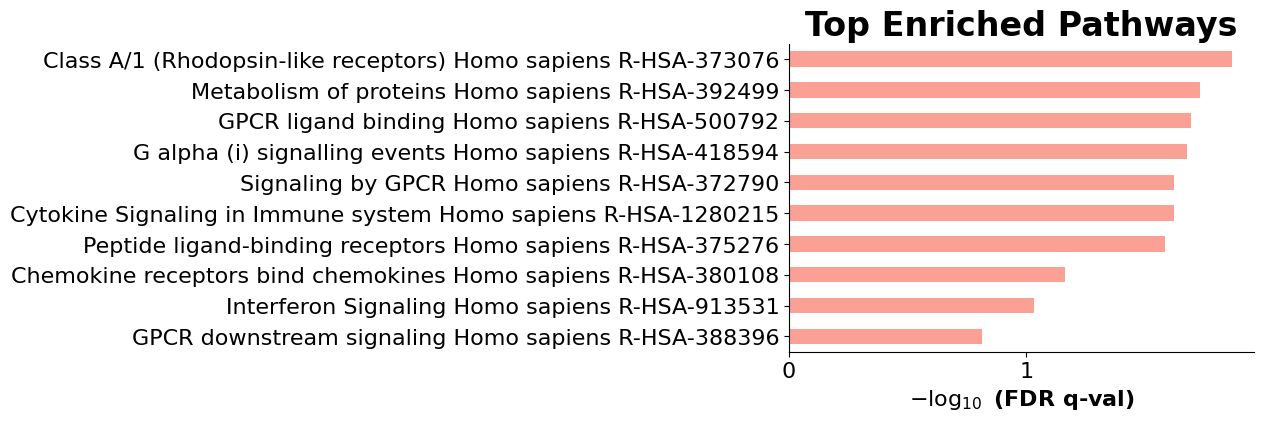

In [18]:
# Gene Set Enrichment Analysis Between Normal Tissue and Tumor Tissue
gsea_results = gp.prerank(
    rnk="gsea_ranked_genes_normalt.rnk",
    gene_sets="Reactome_2016",  
    outdir="GSEA_results",
    seed=123,
    min_size=10,
    max_size=15000
)

print(gsea_results.res2d.columns)
print(gsea_results.res2d.head())
print(gsea_results.res2d.head())

# Plot the enrichment results
gp.barplot(
    gsea_results.res2d,
    title="Top Enriched Pathways",
    figsize=(6, 4),
    column="FDR q-val", 
    cutoff=0.5
)
plt.show()

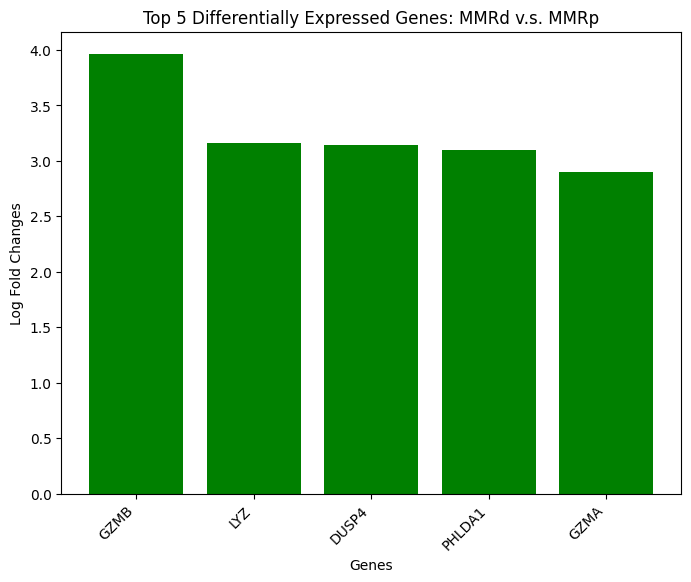

In [16]:
# Create a bar plot of top 5 DEGs
# Sort the DE results by p-value and logFC
de_results_sortednt = de_results_normalt.sort_values(by=['pvals', 'logfoldchanges'], ascending=[True, False])
top_5_genes = de_results_sortednt.head(5)

plt.figure(figsize=(8, 6))
plt.bar(top_5_genes["names"], top_5_genes["logfoldchanges"], color='green')
plt.xlabel("Genes")
plt.ylabel("Log Fold Changes")
plt.title("Top 5 Differentially Expressed Genes: MMRd v.s. MMRp")
plt.xticks(rotation=45, ha="right")  
plt.show()

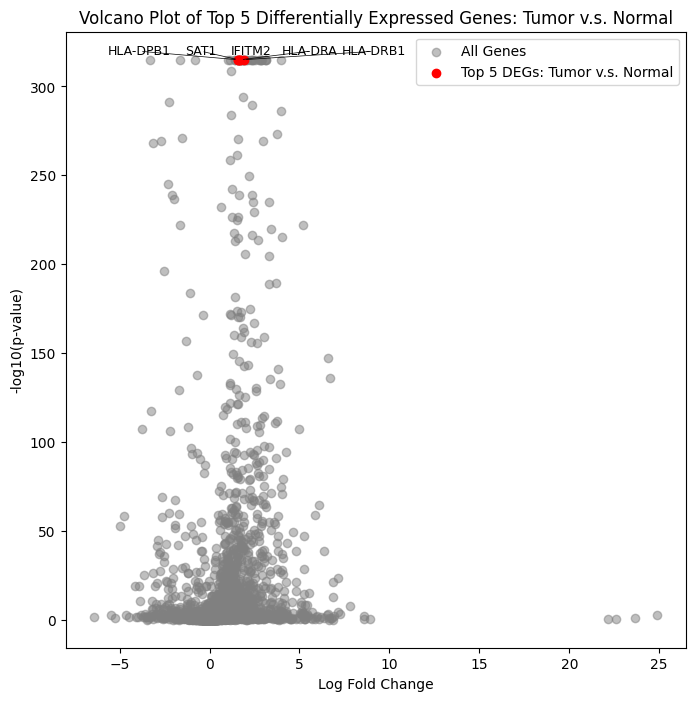

In [ ]:
# Create Volcano Plot
plt.figure(figsize=(8, 8))

# Scatter plot for all genes
plt.scatter(de_results_normalt["logfoldchanges"],
            -np.log10(de_results_normalt["pvals"]),
            alpha=0.5,
            color='grey',
            label="All Genes")

# Highlight top 5 genes in red
top5 = de_results_normalt.iloc[:5]

plt.scatter(top5["logfoldchanges"],
            -np.log10(top5["pvals"]),
            color='red',
            label="Top 5 DEGs: Tumor v.s. Normal")

# Prepare text annotations for adjustText
texts = []
for i, row in top5.iterrows():
    texts.append(
        plt.text(row["logfoldchanges"],
                 -np.log10(row["pvals"]),
                 row["names"],
                 fontsize=9,
                 color='black')
    )

# Adjust the text labels with more spacing control
adjust_text(texts,
            force_points=0.8,
            force_text=0.8,
            expand_points=(2, 2),     # Space between points
            expand_text=(2, 2),       # Space between labels
            arrowprops=dict(arrowstyle="-", color='black', lw=0.5),
         only_move={'points': 'y', 'text': 'xy'},  
         lim=1000)            

# Add labels and title
plt.xlabel('Log Fold Change')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot of Top 5 Differentially Expressed Genes: Tumor v.s. Normal')
plt.legend()
plt.show()


In [ ]:
# Subset the data to only MMRD and MMRP cells
adata_sub = adata[adata.obs['MMRStatus'].isin(['MMRp', 'MMRd'])].copy()

# Perform DE Analysis 
sc.tl.rank_genes_groups(adata_sub, groupby="MMRStatus", method="wilcoxon")

# Extract DE results for MMRD vs MMRP
de_results = sc.get.rank_genes_groups_df(adata_sub, group="MMRd")

# Handle extreme values safely
de_results["pvals"].replace(0, 1e-300, inplace=True)  # Avoid log(0) errors
de_results["logfoldchanges"].replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaNs in logFC with 0 (neutral effect) & p-values with 1 (not significant)
de_results.fillna({"logfoldchanges": 0, "pvals": 1, "pvals_adj": 1}, inplace=True)

# Save Results
de_results.to_csv("MMRD_vs_MMRP_DEGs.csv", index=False)

# Show top genes
print(de_results.head(10))

    names     scores  logfoldchanges          pvals      pvals_adj
0    MT2A  52.256943        1.375977  1.000000e-300   0.000000e+00
1    CCL5  44.651451        1.872918  1.000000e-300   0.000000e+00
2    GZMB  43.182892        2.084113  1.000000e-300   0.000000e+00
3    GZMA  41.995499        1.913632  1.000000e-300   0.000000e+00
4    CCL4  39.764549        1.579251  1.000000e-300   0.000000e+00
5    NKG7  34.843288        1.526161  5.380654e-266  2.006087e-263
6    GNLY  32.978855        2.067555  1.632649e-238  5.217480e-236
7  CXCL13  30.376179        2.658653  1.133780e-202  3.170333e-200
8   KLRD1  30.329231        1.960532  4.721102e-202  1.173456e-199
9    MT1E  29.355377        1.494465  2.040225e-189  4.563982e-187


/var/folders/k9/6ny465s16b10fp__fsd7nx1w0000gn/T/ipykernel_23572/672158735.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  de_results["pvals"].replace(0, 1e-300, inplace=True)  # Avoid log(0) errors
/var/folders/k9/6ny465s16b10fp__fsd7nx1w0000gn/T/ipykernel_23572/672158735.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which

In [96]:
# Subset Immune Cells
immune_categories = ['TNKILC', 'Myeloid', 'B', 'Mast', 'Plasma']
adata_immune = adata[adata.obs['clTopLevel'].isin(immune_categories)].copy()
adata_immune.obs['clTopLevel'].value_counts()

clTopLevel
TNKILC     27736
Plasma     26605
Myeloid    13133
B           7925
Mast        1459
Name: count, dtype: int64

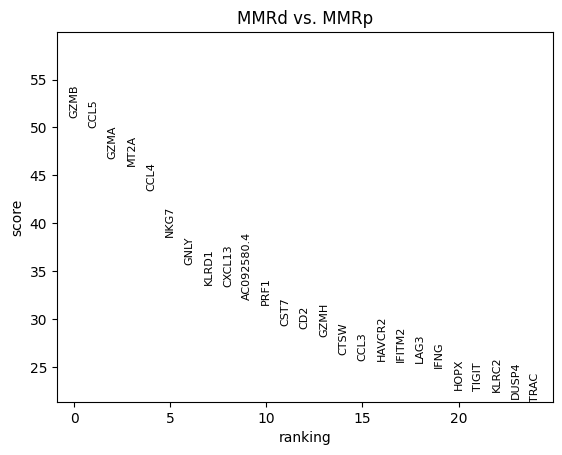

In [98]:
# Run Differential Expression for Immune Cells
sc.tl.rank_genes_groups(adata_immune, groupby='MMRStatus', groups=['MMRd'], reference='MMRp', method='wilcoxon')
sc.pl.rank_genes_groups(adata_immune, n_genes=25, sharey=False)

In [99]:
# Separate dataset into MMRp and MMRd
adata_MMRp = adata_immune[adata_immune.obs['MMRStatus'] == 'MMRp'].copy()
adata_MMRd = adata_immune[adata_immune.obs['MMRStatus'] == 'MMRd'].copy()

In [62]:
# Relative Abundance Analysis
mmrp_counts = adata_MMRp.obs['clTopLevel'].value_counts(normalize=True) * 100
mmrd_counts = adata_MMRd.obs['clTopLevel'].value_counts(normalize=True) * 100

abundance_df = pd.DataFrame({
    'MMRp (%)': mmrp_counts,
    'MMRd (%)': mmrd_counts,
}, index=adata_immune.obs['clTopLevel'].unique())

display(abundance_df)

# Confirm Significance of Relative Abundance with Chi-Square Test
chi2, p, dof, expected = ss.chi2_contingency(abundance_df)
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")

,MMRp (%),MMRd (%)
Myeloid,23.165547,23.709001
Plasma,25.356604,13.685022
Mast,2.448224,1.357369
TNKILC,37.714305,55.215381
B,11.315320,6.033228


Chi-square statistic: 8.712374760159877
P-value: 0.06870488556599738


In [100]:
# Perform PCA and clustering
# For MMRp
sc.tl.pca(adata_MMRp, svd_solver='arpack')
sc.pp.neighbors(adata_MMRp, n_neighbors=10, n_pcs=40)

# For MMRd
sc.tl.pca(adata_MMRd, svd_solver='arpack')
sc.pp.neighbors(adata_MMRd, n_neighbors=10, n_pcs=40)

In [ ]:
# Run Harmony for batch correction (2 minutes)
adata_MMRp.obsm["X_pca_harmony"] = hm.run_harmony(adata_MMRp.obsm["X_pca"], adata_MMRp.obs, 'batch').Z_corr.T # transpose result to fit expected shape
adata_MMRd.obsm["X_pca_harmony"] = hm.run_harmony(adata_MMRd.obsm["X_pca"], adata_MMRd.obs, 'batch').Z_corr.T

2025-03-13 22:16:31,180 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-13 22:16:46,384 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-13 22:16:46,799 - harmonypy - INFO - Iteration 1 of 10
2025-03-13 22:17:05,669 - harmonypy - INFO - Iteration 2 of 10
2025-03-13 22:17:25,290 - harmonypy - INFO - Iteration 3 of 10
2025-03-13 22:17:39,450 - harmonypy - INFO - Converged after 3 iterations
2025-03-13 22:17:39,492 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-13 22:17:47,705 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-13 22:17:47,932 - harmonypy - INFO - Iteration 1 of 10
2025-03-13 22:17:59,291 - harmonypy - INFO - Iteration 2 of 10
2025-03-13 22:18:10,062 - harmonypy - INFO - Iteration 3 of 10
2025-03-13 22:18:20,917 - harmonypy - INFO - Iteration 4 of 10
2025-03-13 22:18:32,018 - harmonypy - INFO - Iteration 5 of 10
2025-03-13 22:18:37,293 - harmonypy - INFO - Converged after

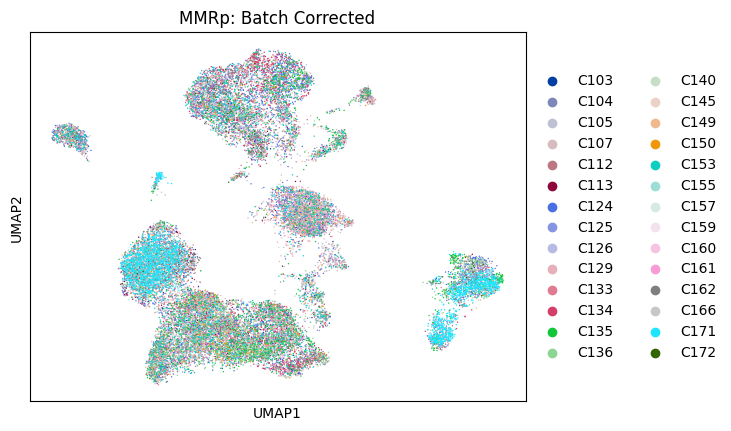

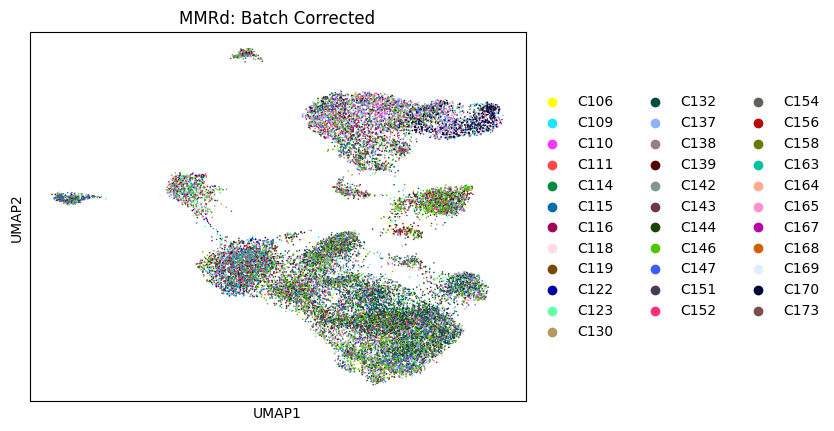

In [104]:
# Update neighbors & recompute UMAP (1.5 minutes)
sc.pp.neighbors(adata_MMRp, use_rep="X_pca_harmony")
sc.tl.umap(adata_MMRp)
sc.pl.umap(adata_MMRp, color="batch", title="MMRp: Batch Corrected")

sc.pp.neighbors(adata_MMRd, use_rep="X_pca_harmony")
sc.tl.umap(adata_MMRd)
sc.pl.umap(adata_MMRd, color="batch", title="MMRd: Batch Corrected")

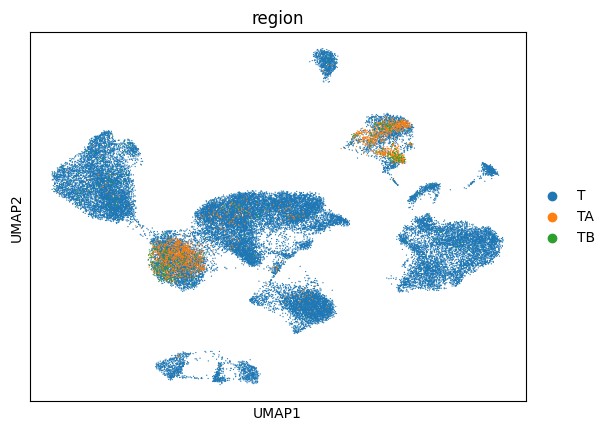

In [12]:
# Verify Teal Cluster is due to Biological Variation not Leftover Batch Effects
sc.pl.umap(adata_MMRp, color=['region'])

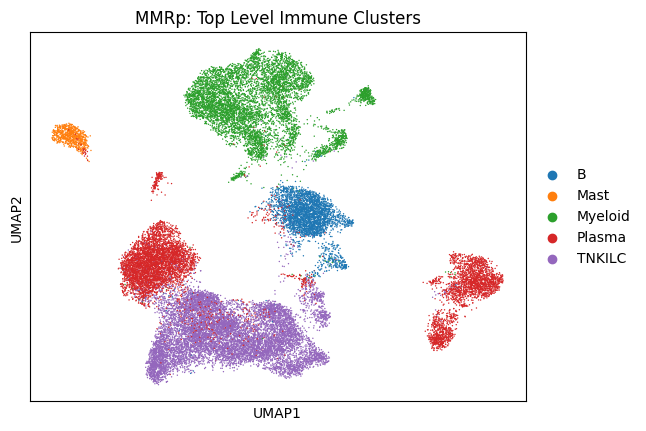

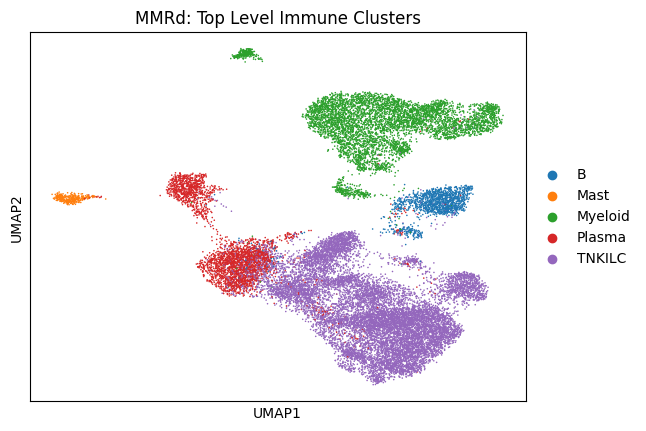

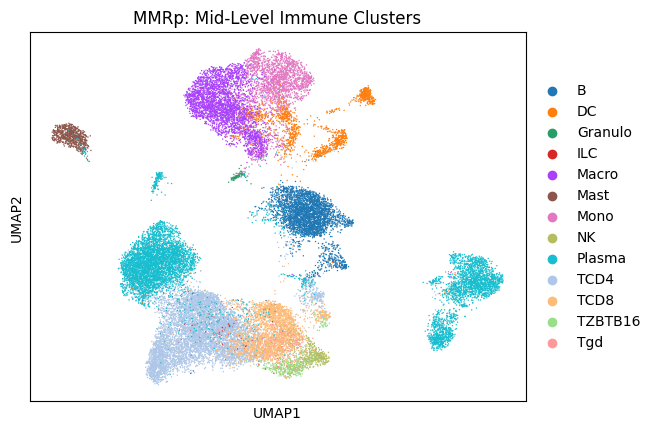

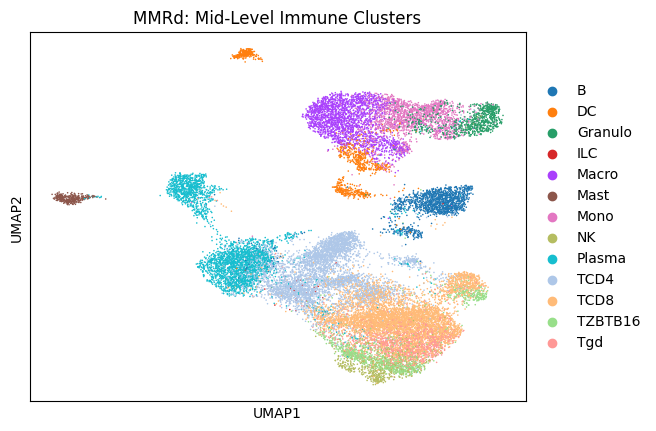

In [ ]:
# Plot top-level UMAPs
sc.pl.umap(adata_MMRp, color='clTopLevel', title='MMRp: Top Level Immune Clusters')
sc.pl.umap(adata_MMRd, color='clTopLevel', title='MMRd: Top Level Immune Clusters')

# Plot mid-level UMAPs
sc.pl.umap(adata_MMRp, color='clMidwayPr', title='MMRp: Mid-Level Immune Clusters')
sc.pl.umap(adata_MMRd, color='clMidwayPr', title='MMRd: Mid-Level Immune Clusters')


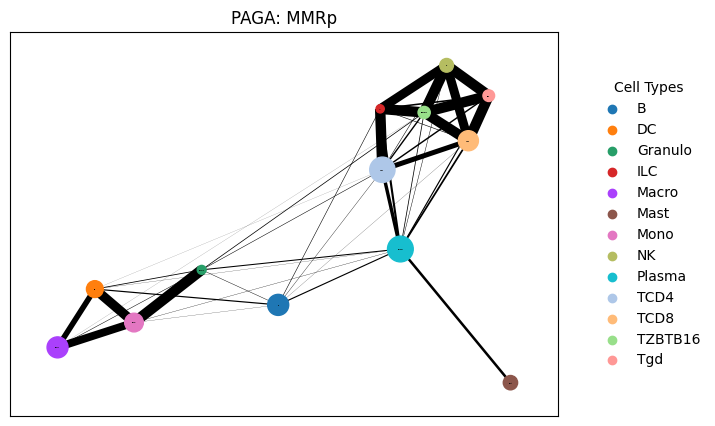

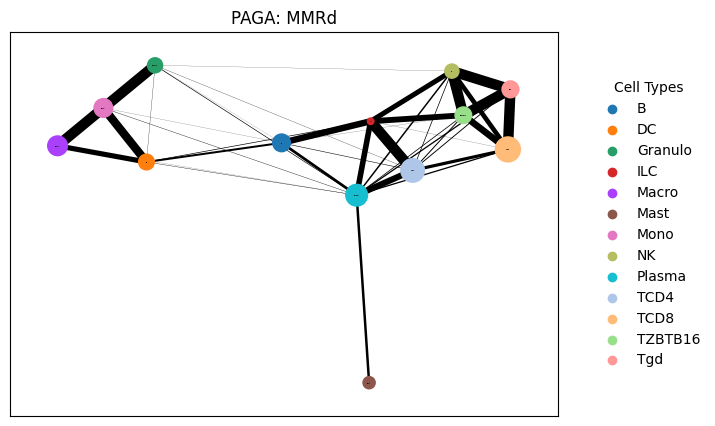

In [ ]:
# Run PAGA for RNA Trajectory Analysis
sc.tl.paga(adata_MMRp, groups='clMidwayPr')
sc.tl.paga(adata_MMRd, groups='clMidwayPr')

# Plot PAGA Graph for MMRp
mmrp_paga = sc.pl.paga(adata_MMRp, color='clMidwayPr', fontsize=0, layout='fr',title='PAGA: MMRp', show=False)

# Get categories & colors
categories_mmrp = adata_MMRp.obs['clMidwayPr'].cat.categories
colors_mmrp = adata_MMRp.uns['clMidwayPr_colors']

# Create Legend
for label, color in zip(categories_mmrp, colors_mmrp):
    mmrp_paga.scatter([], [], color=color, label=label)

mmrp_paga.legend(loc='center left',
          bbox_to_anchor=(1.05, 0.5),
          frameon=False,
          title='Cell Types')
plt.show()

# Plot PAGA Graph for MMRd
mmrd_paga = sc.pl.paga(adata_MMRd, color='clMidwayPr', fontsize=0, layout='fr',title='PAGA: MMRd', show=False)

# Get categories & colors
categories_mmrd = adata_MMRd.obs['clMidwayPr'].cat.categories
colors_mmrd = adata_MMRd.uns['clMidwayPr_colors']

# Create Legend
for label, color in zip(categories_mmrd, colors_mmrd):
    mmrd_paga.scatter([], [], color=color, label=label)

mmrd_paga.legend(loc='center left',
          bbox_to_anchor=(1.05, 0.5),
          frameon=False,
          title='Cell Types')
plt.show()

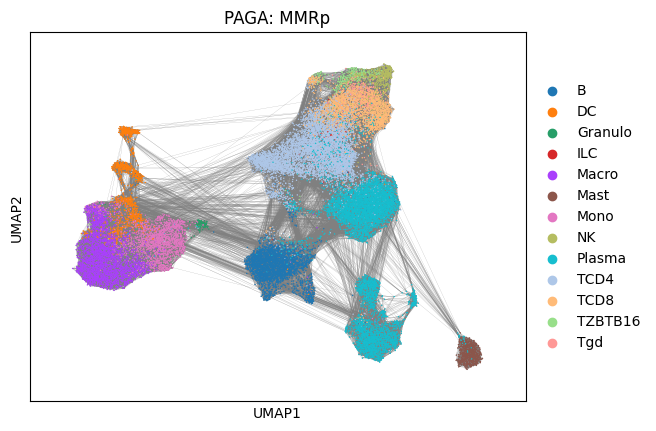

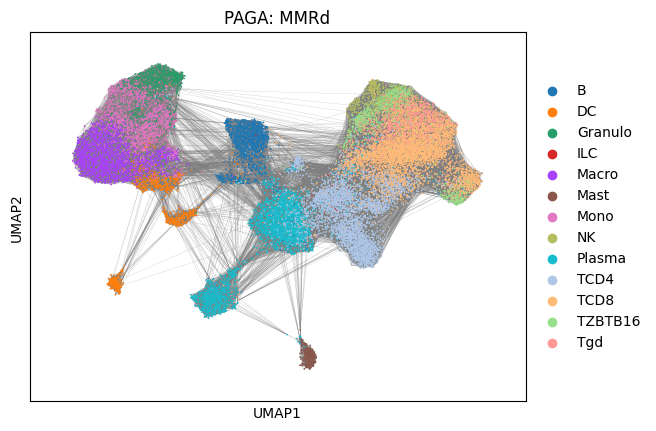

In [45]:
# Overlay PAGA on UMAP
sc.tl.umap(adata_MMRp, init_pos='paga')
sc.tl.umap(adata_MMRd, init_pos='paga')

sc.pl.umap(adata_MMRp, color=['clMidwayPr'], edges=True, title="PAGA: MMRp")
sc.pl.umap(adata_MMRd, color=['clMidwayPr'], edges=True, title="PAGA: MMRd")

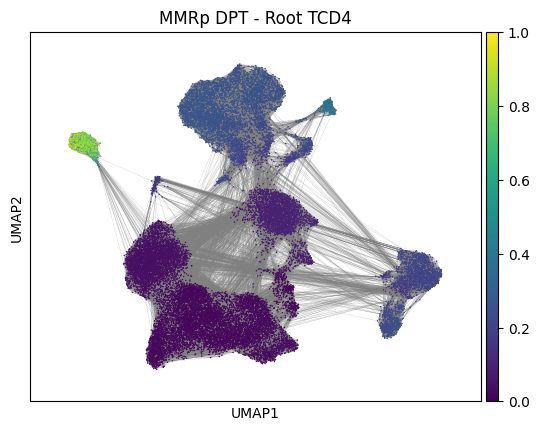

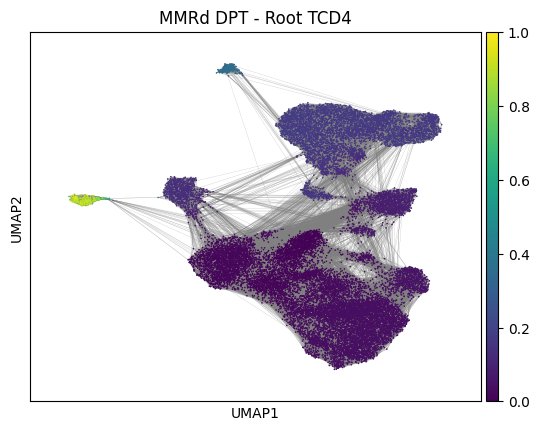

In [75]:
# Perform RNA Trajectory Analysis for MMRp and MMRd
# Pick root cluster label
root_cluster_label_MMRp = 'TCD4'  
root_cluster_label_MMRd = 'TCD4'  

# Find a cell index in that cluster to set as root
root_cell_index_MMRp = adata_MMRp.obs.query('clMidwayPr == @root_cluster_label_MMRp').index[0]
root_cell_index_MMRd = adata_MMRd.obs.query('clMidwayPr == @root_cluster_label_MMRd').index[0]

# Assign the root cell
adata_MMRp.uns['iroot'] = adata_MMRp.obs_names.get_loc(root_cell_index_MMRp)
adata_MMRd.uns['iroot'] = adata_MMRd.obs_names.get_loc(root_cell_index_MMRd)

# Run Diffusion Pseudotime
sc.tl.dpt(adata_MMRp)
sc.tl.dpt(adata_MMRd)

# Create new UMAP
sc.pl.umap(adata_MMRp, color='dpt_pseudotime', edges=True, title='MMRp DPT - Root TCD4')
sc.pl.umap(adata_MMRd, color='dpt_pseudotime', edges=True, title='MMRd DPT - Root TCD4')



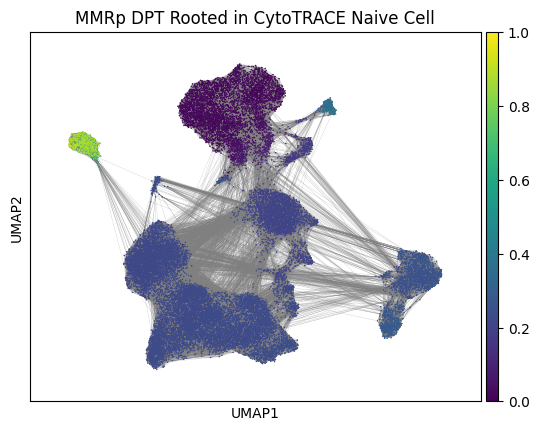

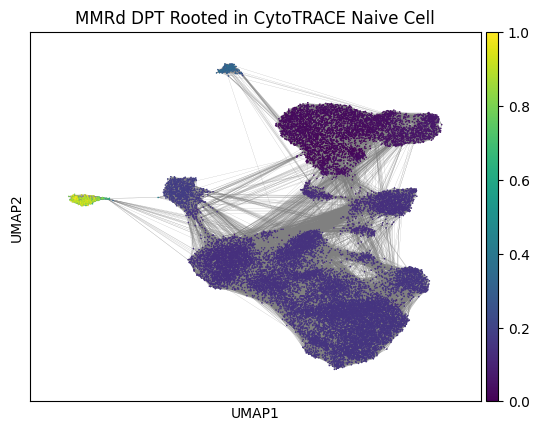

In [107]:
# Sort cells by CytoTRACE score (highest = most naive)
sorted_cells_MMRp = adata_MMRp.obs.sort_values(by='CytoTRACE', ascending=False)
sorted_cells_MMRd = adata_MMRd.obs.sort_values(by='CytoTRACE', ascending=False)

# Pick the top-scoring cell
root_cell_index_MMRp = sorted_cells_MMRp.index[0]
root_cell_index_MMRd = sorted_cells_MMRd.index[0]

# Assign as the root in DPT
adata_MMRp.uns['iroot'] = adata_MMRp.obs_names.get_loc(root_cell_index_MMRp)
adata_MMRd.uns['iroot'] = adata_MMRd.obs_names.get_loc(root_cell_index_MMRd)

# Run Diffusion Pseudotime
sc.tl.dpt(adata_MMRp)
sc.tl.dpt(adata_MMRd)

# Plot DPT on UMAP (or original UMAP)
sc.pl.umap(adata_MMRp, color=['dpt_pseudotime'], edges=True, title='MMRp DPT Rooted in CytoTRACE Naive Cell')
sc.pl.umap(adata_MMRd, color=['dpt_pseudotime'], edges=True, title='MMRd DPT Rooted in CytoTRACE Naive Cell')